In [1]:
#import pyspark
#sc = pyspark.SparkContext.getOrCreate()
#sqlContext = pyspark.sql.SQLContext(sc)
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, VectorAssembler
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.types import ArrayType, IntegerType, StringType
import xlrd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [3]:

def read_excel_xlrd(path):
    xl_workbook = xlrd.open_workbook(path)
    #sheet_names = xl_workbook.sheet_names()
    #print('Sheet Names', sheet_names)
    #xl_sheet = xl_workbook.sheet_by_name(sheet_names[0])
    xl_sheet = xl_workbook.sheet_by_index(0)
    #print ('Sheet name: %s' % xl_sheet.name)
    data = []
    for row in range(xl_sheet.nrows):
        line = []
        for col in range(xl_sheet.ncols):
            line.append(str(xl_sheet.cell(row, col).value))
        data.append(line)
    columnNames = data[0]
    dataValues = data[1:]
    dataPairs = []
    for row in range(len(dataValues)):
        line = {}
        for col in range(len(columnNames)):
            line[columnNames[col]] = dataValues[row][col]
        dataPairs.append(Row(**line))
    dataRDD = sc.parallelize(dataPairs)
    df = dataRDD.toDF()
    return df

def items_get(df, columnName, delimiter=None):
    rows = df.groupBy(columnName).count().collect()
    results = []
    for row in rows:
        if delimiter!=None: 
            for item in row[columnName].split(delimiter):
                if item not in results:
                    results.append(item)
        else:
            if row[columnName] not in results:
                results.append(row[columnName])
    results.sort()
    return results

def exist_list(list_all, list_compared):
    results = []
    for item in list_all:
        if item in list_compared:
            results.append(1)
        else:
            results.append(0)
    return results

def df_column_add(df, input_colName, output_colName, function, returnType):
    function_udf = udf(lambda item: function(item), returnType)
    return df.withColumn(output_colName, function_udf(col(input_colName)))

def countEmptyAndNull(df):
    for columnName in df.columns:
        print(r"Column '%s' has %d '', %d 'noInfo', %d 'None', %d filled, and %d null rows." 
              % (columnName, df.filter(df[columnName]=='').count(), df.filter(df[columnName]=='noInfo').count(),
                 df.filter(df[columnName]=='None').count(), df.filter(df[columnName]!='').count(),
                 df.filter(df[columnName].isNull()).count()))


In [4]:
df = read_excel_xlrd("lib-statistics.xlsx")
print(df.filter(df['Ödünç Sayısı'].isNull()).count())
print(df.filter(df['Ödünç Sayısı']=='').count())
df = df.withColumn('Sınıflama', split(df['Sınıflama'], " ")[0])
df = df.withColumn('Ödünç Sayısı', df['Ödünç Sayısı'].cast('float'))
print(df.filter(df['Ödünç Sayısı'].isNull()).count())
df = df.fillna({'Sınıflama' : 'noInfo', 'Eser Adı' : 'noInfo', 'Yazar' : 'noInfo', 'Dil' : 'noInfo', 'Konu Başlıkları' : 'noInfo' , 'Ödünç Sayısı' : 0.0})
print(df.filter(df['Ödünç Sayısı'].isNull()).count())

0
598
598
0


In [5]:
df.select(sum(df['Ödünç Sayısı'])).show()

+-----------------+
|sum(Ödünç Sayısı)|
+-----------------+
|            339.0|
+-----------------+



In [6]:
df.printSchema()

root
 |-- Dil: string (nullable = false)
 |-- Eser Adı: string (nullable = false)
 |-- Konu Başlıkları: string (nullable = false)
 |-- Sınıflama: string (nullable = false)
 |-- Yazar: string (nullable = false)
 |-- Ödünç Sayısı: float (nullable = false)



In [7]:
df.show()

+---+--------------------+--------------------+---------+--------------------+------------+
|Dil|            Eser Adı|     Konu Başlıkları|Sınıflama|               Yazar|Ödünç Sayısı|
+---+--------------------+--------------------+---------+--------------------+------------+
|eng|Museum frictions ...|Museums--Social A...|       AM|                    |         0.0|
|tur|Tahayyül gücünü y...|Imagination (Phil...|        B|                    |         0.0|
|tur|Bir yol var : Min...|Ontology
Stress M...|        B|        Damcı, Taner|         0.0|
|tur|Psikoloji şerhi =...|Aristotle
Aristot...|        B|            İbn Rüşd|         2.0|
|eng|An examination of...|Özel, İsmet, 1944...|        B|      Kaya, Vefa Can|         0.0|
|eng|An examination of...|Özel, İsmet, 1944...|        B|      Kaya, Vefa Can|         0.0|
|tur|Ruhun uyanışı, ya...|Philosophy, Islam...|        B|İbn Ṭufeyl, Muḥam...|         0.0|
|tur|Çağımızın sorunla...|Philosophy, Moder...|        B|   Russell, Bertrand|  

In [8]:
df.filter(df['Konu Başlıkları']=='').show()
df.filter(df['Konu Başlıkları']=='noInfo').show()
df.filter(df['Konu Başlıkları']=='None').show()
df.filter(df['Konu Başlıkları'].isNull()).show()
df.filter(df['Ödünç Sayısı'] != 0.0).count()

+---+--------------------+---------------+---------+--------------------+------------+
|Dil|            Eser Adı|Konu Başlıkları|Sınıflama|               Yazar|Ödünç Sayısı|
+---+--------------------+---------------+---------+--------------------+------------+
|tur|Edebiyat tarihi y...|               |       PL|Erünsal, İsmail E.|         1.0|
+---+--------------------+---------------+---------+--------------------+------------+

+---+--------+---------------+---------+-----+------------+
|Dil|Eser Adı|Konu Başlıkları|Sınıflama|Yazar|Ödünç Sayısı|
+---+--------+---------------+---------+-----+------------+
+---+--------+---------------+---------+-----+------------+

+---+--------+---------------+---------+-----+------------+
|Dil|Eser Adı|Konu Başlıkları|Sınıflama|Yazar|Ödünç Sayısı|
+---+--------+---------------+---------+-----+------------+
+---+--------+---------------+---------+-----+------------+

+---+--------+---------------+---------+-----+------------+
|Dil|Eser Adı|Konu Baş

153

In [9]:
countEmptyAndNull(df)

Column 'Dil' has 0 '', 0 'noInfo', 0 'None', 751 filled, and 0 null rows.
Column 'Eser Adı' has 0 '', 0 'noInfo', 0 'None', 751 filled, and 0 null rows.
Column 'Konu Başlıkları' has 1 '', 0 'noInfo', 0 'None', 750 filled, and 0 null rows.
Column 'Sınıflama' has 0 '', 0 'noInfo', 0 'None', 751 filled, and 0 null rows.
Column 'Yazar' has 294 '', 0 'noInfo', 0 'None', 457 filled, and 0 null rows.
Column 'Ödünç Sayısı' has 0 '', 0 'noInfo', 0 'None', 0 filled, and 0 null rows.


In [10]:
df.count()

751

In [11]:
def plot_countEmptyAndNull(df, columnName):
    groups = np.empty(group_count, dtype="S30")
    counts = np.empty(group_count)
    list_groups = ["''", "'noInfo'", "'None'", "filled", "null"]
    list_counts = [df.filter(df[columnName]=='').count(), df.filter(df[columnName]=='noInfo').count(),
             df.filter(df[columnName]=='None').count(), df.filter(df[columnName]!='').count(),
             df.filter(df[columnName].isNull()).count()]
    for index in range(len(list_counts)):
        groups[index] = list_groups[index]
        counts[index] = list_counts[index]
    sns.barplot(x=groups, y=counts)
    plt.xticks(rotation='vertical')
    sns.despine()

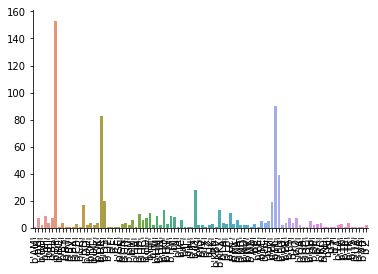

In [12]:
df_group = df.groupBy('Sınıflama').count().orderBy("Sınıflama")
group_count = df_group.count()
groups = np.empty(group_count, dtype="S30")
counts = np.empty(group_count)
for (index,row) in enumerate(df_group.collect()):
    groups[index] = row['Sınıflama']
    counts[index] = row['count']
sns.barplot(x=groups, y=counts)
plt.xticks(rotation='vertical')
sns.despine()

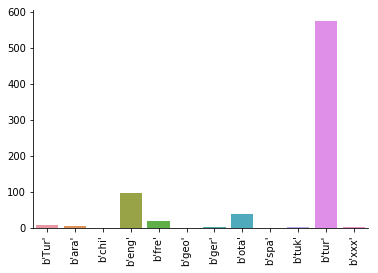

In [13]:
df_lang = df.groupBy(df['Dil']).count().orderBy('Dil')
lang_count = df_lang.count()
langs = np.empty(lang_count, dtype="S30")
counts = np.empty(lang_count)
for (index,row) in enumerate(df_lang.collect()):
    langs[index] = row['Dil']
    counts[index] = row['count']
sns.barplot(x=langs, y=counts)
plt.xticks(rotation='vertical')
sns.despine()

In [14]:
#df_writer = df.groupBy(df['Yazar']).count().orderBy('Yazar')
#writer_count = df_writer.count()
#writers = np.empty(writer_count, dtype="S30")
#counts = np.empty(writer_count)
#for (index,row) in enumerate(df_writer.collect()):
#    writers[index] = (row['Yazar'])
#    counts[index] = row['count']
#sns.barplot(x=writers, y=counts)
#plt.xticks(rotation='vertical')
#sns.despine()

In [15]:
def function_topics(item): list1 = item.replace(' ', '_').split('\n'); list1.sort(); return ' '.join(list1)

df_1 = df_column_add(df, 'Konu Başlıkları', 'topicTitles str', function_topics, StringType())

categories = items_get(df, 'Sınıflama')
def label_categories(item): return categories.index(item)

df_1 = df_column_add(df_1, 'Sınıflama', 'category_label', label_categories, IntegerType())

topics = items_get(df, 'Konu Başlıkları', '\n')

def function_topics_existList(item): return exist_list(topics, item.split('\n'))

df_2 = df_column_add(df, 'Konu Başlıkları', 'topicTitles exist_list', function_topics_existList, ArrayType(IntegerType()))


In [16]:
tokenizer = Tokenizer(inputCol='topicTitles str', outputCol='words')
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol='features')
#assembler = VectorAssembler(inputCols=['features_topics', 'Ödünç Sayısı'], outputCol='features')
lr = LogisticRegression(maxIter=10, regParam=0.01, labelCol='category_label')
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

#model = pipeline.fit(df_1)

#test = sqlContext.createDataFrame([
#    Row(text="You will get a prize. To claim call 09061701461. Claim code KL341. Valid 12 hours only."),
#    Row(text="Even my brother is not like to speak with me. They treat me like aids patent.")])

#prediction = model.transform(test)

In [17]:
df2 = df.groupBy('Dil').count()
df2.select(sum(df2['count'])).show()

df.select(sum(df['Ödünç Sayısı'])).show()

print(df.filter(df['Ödünç Sayısı'].isNull()).count())

df.groupBy(df['Sınıflama']).count().show()

df_s = df.groupBy(df['Sınıflama']).count()
print(df_s.filter(df_s['count'] > 1).count())
print(df_s.filter(df_s['count'] < 1).count())
print(df_s.filter(df_s['count'] == 1).count())

+----------+
|sum(count)|
+----------+
|       751|
+----------+

+-----------------+
|sum(Ödünç Sayısı)|
+-----------------+
|            339.0|
+-----------------+

0
+---------+-----+
|Sınıflama|count|
+---------+-----+
|        K|    3|
|       UA|    1|
|       LA|    4|
|       BS|    4|
|       NK|    2|
|       AM|    1|
|       PL|   90|
|       PS|    7|
|       DR|   83|
|        F|    1|
|       JF|    1|
|       BP|  153|
|       NX|    1|
|        Q|    7|
|       JC|    6|
|       NA|    6|
|       HV|    9|
|       BX|    1|
|       VA|    1|
|        E|    1|
+---------+-----+
only showing top 20 rows

66
0
30


In [18]:
df_s.filter(df_s['Sınıflama'].like('%D%')).orderBy('Sınıflama').show()

+---------+-----+
|Sınıflama|count|
+---------+-----+
|       BD|    2|
|        D|   17|
|       DD|    2|
|       DF|    4|
|       DG|    2|
|       DK|    4|
|       DR|   83|
|       DS|   20|
|       DT|    1|
|       HD|    7|
|       ND|    2|
|       RD|    1|
+---------+-----+



In [19]:
#df.groupBy(df['Sınıflama']).agg(collect_list('Konu Başlıkları').alias('gruplanmış konu başlıkları')).show()
df.groupBy(df['Sınıflama']).agg(collect_list('Konu Başlıkları'), collect_list('Yazar')).show()
#df.filter(df['Ödünç Sayısı'] != 0.0).select("Eser Adı").collect()

+---------+-----------------------------+--------------------+
|Sınıflama|collect_list(Konu Başlıkları)| collect_list(Yazar)|
+---------+-----------------------------+--------------------+
|        K|         [Family--Ethics--...|[Ataseven, Gülsen...|
|       UA|         [North Atlantic T...| [Jordan, Robert S.]|
|       LA|         [Cevdet, Mehmed, ...|[Ergin, Osman Nur...|
|       BS|         [Turkish Literatu...|[Göçmenoğlu, Kası...|
|       NK|         [Hilye-i Şerif--E...|[, Kuşoğlu, Mehme...|
|       AM|         [Museums--Social ...|                  []|
|       PL|         [Turkish Language...|[Yüzendağ, Ahmet,...|
|       PS|         [Rich People--Fic...|[Fitzgerald, Fran...|
|       DR|         [Insurgency--Serb...|[Özkan, Ayşe, , ,...|
|        F|         [California, Sout...|       [Sanger, Kay]|
|       JF|         [Executive Power-...|                  []|
|       BP|         [Islam--Periodica...|[, , , , , , , , ...|
|       NX|         [Piri Reis--Maps-...|              

In [20]:
####

In [21]:
def function_topics(item):  
    if item!='': list1 = item.replace(' ', '_').split('\n'); list1.sort(); return ' '.join(list1)
    else: return 'empty'

df_test = df_column_add(df, 'Konu Başlıkları', 'topicTitles str', function_topics, StringType())
categories = items_get(df, 'Sınıflama')
df_test = df_column_add(df_test, 'Sınıflama', 'category_label', label_categories, IntegerType())


In [22]:
tokenizer = Tokenizer(inputCol='topicTitles str', outputCol='words')
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol='features')
#assembler = VectorAssembler(inputCols=['features_topics', 'Ödünç Sayısı'], outputCol='features')
lr = LogisticRegression(maxIter=10, regParam=0.01, labelCol='category_label')
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

#model = pipeline.fit(df_test)

#test = sqlContext.createDataFrame([
#    Row(text="You will get a prize. To claim call 09061701461. Claim code KL341. Valid 12 hours only."),
#    Row(text="Even my brother is not like to speak with me. They treat me like aids patent.")])

#prediction = model.transform(test)

In [65]:
# Hamming distance gives the probability that the two items are not similar
def hamming(x,y):
    """Calculate the Hamming distance between two vectors"""
    assert len(x) == len(y)
    c = 0
    for i in range(0, len(x)):
        if x[i] != y[i]:
            c += 1
    return c * 1.0/ len(x)
#### reference: https://github.com/kirkhunter/PySpark-recommender-system/blob/master/scripts-Mrun/LSH_Cosine_Similarity.py

In [24]:
def search_df(df, inputStr, inputCol, orderBy=None, searchLike=False):
    if orderBy==None: orderBy=inputCol
    if searchLike: 
        search_str = '%' + str(inputStr) + '%'
    else:
        search_str = str(inputStr)
    columnNames = [col for col in df.columns]
    df_distinct = df.select(columnNames).distinct()
    collectListDict = {}
    for index in range(len(columnNames)):
        if columnNames[index] != inputCol:
            collectListDict[columnNames[index]] = 'collect_list'
    search = df_distinct.groupBy(inputCol).agg(collectListDict).orderBy(orderBy).filter(df[inputCol].like(search_str))
    return search


In [25]:
columnNames = [col for col in df.columns]
print(columnNames)
print(len(columnNames))
print(df.select('Eser Adı').distinct().count())
print(df.select(columnNames).distinct().select('Eser Adı').count())
print(df.groupBy('Eser Adı').count().count()==df.select(columnNames).distinct().groupBy('Eser Adı').count().count())
print(df.select(columnNames).distinct().groupBy('Eser Adı').count().count())

['Dil', 'Eser Adı', 'Konu Başlıkları', 'Sınıflama', 'Yazar', 'Ödünç Sayısı']
6
673
683
True
673


In [26]:
df_distinct = df.select('Eser Adı').distinct()
str1 = df_distinct.collect()[0]['Eser Adı']
search_df(df, str1, 'Eser Adı').collect()

[Row(Eser Adı='T.C. Temsilciler Meclisi tutanak dergisi : genel fihrist', collect_list(Konu Başlıkları)=['Legislation--Turkey--Periodicals\nTurkey--Politics and Government--Periodicals\nMevzuat--Türkiye--Süreli Yayınlar\nTürkiye--Siyaset ve Yönetim--Süreli Yayınlar'], collect_list(Yazar)=[''], collect_list(Dil)=['tur'], collect_list(Ödünç Sayısı)=[0.0], collect_list(Sınıflama)=['J'])]

In [102]:
def function_topicsList_existList(itemList): 
    return [exist_list(topics, item.split('\n')) for item in itemList]

def topicExistList_compare(itemList_1, itemList_2):
    resultList = []
    assert len(itemList_1) == len(itemList_2)
    for item in itemList_1:
        list1 = []
        for item2 in itemList_2:
            list1.append(hamming(item,item2))
        resultList.append(list1)
    averageResults = []
    for list2 in resultList:
        sum1 = 0
        for num in list2:
            sum1 += num
        averageResults.append(sum1/len(list2))
    return averageResults

def hamming_topicTitles_df(df, list_all, inputStr, inputCol):
    orderBy = inputCol
    search_str = str(inputStr)
    columnNames = [col for col in df.columns]
    df_distinct = df.select(columnNames).distinct()
    collectListDict = {}
    for index in range(len(columnNames)):
        if columnNames[index] != inputCol:
            collectListDict[columnNames[index]] = 'collect_list'
    df_groupBy_inputCol = df_distinct.groupBy(inputCol).agg(collectListDict).orderBy(orderBy)
    df_groupBy_inputCol = df_column_add(df_groupBy_inputCol, 
                                        'collect_list(Konu Başlıkları)', 
                                        'topicTitles-exist_list', 
                                        function_topicsList_existList, 
                                        ArrayType(ArrayType(IntegerType())))
    search = df_groupBy_inputCol.filter(df[inputCol]==search_str)
    searchTopics = search.collect()[0]['topicTitles-exist_list']
    compareDF = df_groupBy_inputCol.filter(df[inputCol]!=search_str)
    function_udf = udf(lambda itemList: topicExistList_compare(searchTopics, itemList), ArrayType(IntegerType()))
    result = compareDF.withColumn('topicTitles--hamming', function_udf(col('topicTitles-exist_list')))
    
    return result

In [103]:
test111=hamming_topicTitles_df(df, items_get(df, 'Konu Başlıkları', '\n'), df_distinct.collect()[0]['Eser Adı'], 'Eser Adı')

In [105]:
test111.collect()[0]

Py4JJavaError: An error occurred while calling o1544.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 30 in stage 369.0 failed 1 times, most recent failure: Lost task 30.0 in stage 369.0 (TID 23933, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\nejat\Desktop\APACHE~1\Lib\spark_lib\spark-2.3.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 229, in main
  File "C:\Users\nejat\Desktop\APACHE~1\Lib\spark_lib\spark-2.3.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 224, in process
  File "C:\Users\nejat\Desktop\APACHE~1\Lib\spark_lib\spark-2.3.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\serializers.py", line 324, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "C:\Users\nejat\Desktop\APACHE~1\Lib\spark_lib\spark-2.3.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\serializers.py", line 139, in dump_stream
    for obj in iterator:
  File "C:\Users\nejat\Desktop\APACHE~1\Lib\spark_lib\spark-2.3.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\serializers.py", line 313, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "C:\Users\nejat\Desktop\APACHE~1\Lib\spark_lib\spark-2.3.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 74, in <lambda>
  File "C:\Users\nejat\Desktop\APACHE~1\Lib\spark_lib\spark-2.3.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 66, in <lambda>
  File "<ipython-input-102-2619873dbc9f>", line 38, in <lambda>
  File "<ipython-input-102-2619873dbc9f>", line 6, in topicExistList_compare
AssertionError

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:83)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:66)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:253)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1587)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1586)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1586)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1820)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1769)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1758)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2027)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2048)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2067)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2092)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:938)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:297)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply$mcI$sp(Dataset.scala:3195)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3192)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3192)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:3225)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3192)
	at sun.reflect.GeneratedMethodAccessor190.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\nejat\Desktop\APACHE~1\Lib\spark_lib\spark-2.3.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 229, in main
  File "C:\Users\nejat\Desktop\APACHE~1\Lib\spark_lib\spark-2.3.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 224, in process
  File "C:\Users\nejat\Desktop\APACHE~1\Lib\spark_lib\spark-2.3.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\serializers.py", line 324, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "C:\Users\nejat\Desktop\APACHE~1\Lib\spark_lib\spark-2.3.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\serializers.py", line 139, in dump_stream
    for obj in iterator:
  File "C:\Users\nejat\Desktop\APACHE~1\Lib\spark_lib\spark-2.3.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\serializers.py", line 313, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "C:\Users\nejat\Desktop\APACHE~1\Lib\spark_lib\spark-2.3.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 74, in <lambda>
  File "C:\Users\nejat\Desktop\APACHE~1\Lib\spark_lib\spark-2.3.0-bin-hadoop2.7\python\lib\pyspark.zip\pyspark\worker.py", line 66, in <lambda>
  File "<ipython-input-102-2619873dbc9f>", line 38, in <lambda>
  File "<ipython-input-102-2619873dbc9f>", line 6, in topicExistList_compare
AssertionError

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:83)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:66)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:253)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:830)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [29]:
topicTitles111 = items_get(df, 'Konu Başlıkları', '\n')

In [35]:
exist_lists = []
for item in test111:
    exist_lists.append(exist_list(topicTitles111, item.split("\n")))
sum = 0
for i in exist_lists[0]:
    sum+=i
print(sum)
len(test111[0].split("\n"))

4


4

In [34]:
exist_list(topicTitles111, test111[0].split("\n"))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [44]:
inputCol = 'Eser Adı'
orderBy = 'Eser Adı'
columnNames = [col for col in df.columns]
df_distinct = df.select(columnNames).distinct()
collectListDict = {}
for index in range(len(columnNames)):
    if columnNames[index] != inputCol:
        collectListDict[columnNames[index]] = 'collect_list'
search = df_distinct.groupBy(inputCol).agg(collectListDict).orderBy(orderBy)


df_222 = df_column_add(search, 'collect_list(Konu Başlıkları)', 'topicTitles-exist_list', function_topicsList_existList, ArrayType(ArrayType(IntegerType())))
df_222.show()


+--------------------+-----------------------------+--------------------+-----------------+--------------------------+-----------------------+----------------------+
|            Eser Adı|collect_list(Konu Başlıkları)| collect_list(Yazar)|collect_list(Dil)|collect_list(Ödünç Sayısı)|collect_list(Sınıflama)|topicTitles-exist_list|
+--------------------+-----------------------------+--------------------+-----------------+--------------------------+-----------------------+----------------------+
|18 Mart 1915 Çana...|         [World War, 1914-...|     [Ulurasba, Ali]|            [tur]|                     [0.0]|                    [D]|  [[0, 0, 0, 0, 0, ...|
|18 beyit dinle : ...|         [Jalal Al-Din Rum...|  [Çıtlak, M. Fatih]|            [tur]|                     [0.0]|                   [BP]|  [[0, 0, 0, 0, 0, ...|
|1897 Türk-Yunan ...|         [Greco-Turkish Wa...|                  []|            [ota]|                     [0.0]|                   [DF]|  [[0, 0, 0, 0, 0, ...|
|19.

In [76]:
topicExistList_compare([[0,1,1,0],[1,1,1,1]],[[1,1,1,1],[1,1,1,1]])

[0.5, 0.0]

In [67]:
hamming([0,1,1,0],[1,1,1,1])

0.5

In [74]:
a=[0,1,2]
sum1 = 0
for num in a:
    sum1 += num
sum1

3